# Ultrasound Image Segmentation with U-Net

This notebook is designed to guide you through the process of performing image segmentation on ultrasound images using a U-Net model. You will learn how to prepare the dataset, visualize images, define the U-Net architecture, and train the model. Some parts of the code are left as `TODO` for you to complete.


In [1]:
import gdown
url = 'https://drive.google.com/uc?id=1L9HvScE5csRhG9tyrjYmOb3ROmW6Qs1r'
output = 'downloaded_file.zip'

# Download the file
gdown.download(url, output, quiet=False)

import zipfile
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("dataset")


Downloading...
From (original): https://drive.google.com/uc?id=1L9HvScE5csRhG9tyrjYmOb3ROmW6Qs1r
From (redirected): https://drive.google.com/uc?id=1L9HvScE5csRhG9tyrjYmOb3ROmW6Qs1r&confirm=t&uuid=6419968b-73a9-45fe-bc9c-fd6d1c518c72
To: /Users/arengolazizian/Downloads/DL_HW2 (1) (1)/downloaded_file.zip
100%|██████████| 177M/177M [02:34<00:00, 1.15MB/s] 


## Visualizing Annotations

Visualize the specified annotation to understand the data better.


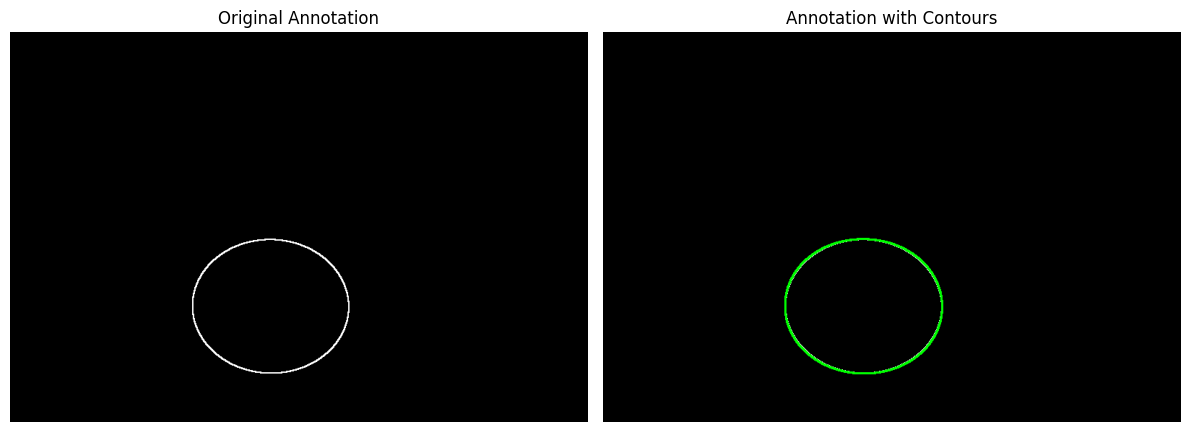

Number of contours found: 1


In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

annotation = "dataset/training_set/training_set/100_2HC_Annotation.png"
image = cv2.imread(annotation, cv2.IMREAD_GRAYSCALE)

contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

color_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(color_image, contours, -1, (0, 255, 0), 2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Annotation')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))
plt.title('Annotation with Contours')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of contours found: {len(contours)}")

## Image Preprocessing

We need to pad images to make them square for the U-Net model.


torch.Size([1, 812, 812])


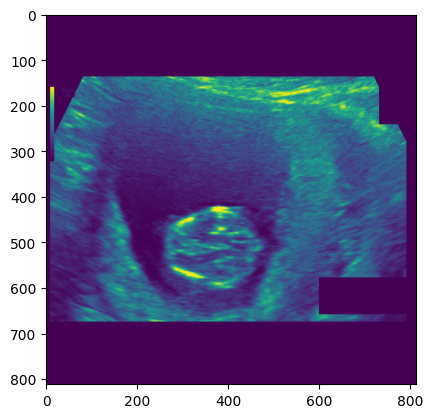

In [7]:
import numpy as np
from PIL import Image
from torchvision.io import read_image
import torch
import matplotlib.pyplot as plt

def pad_image_to_square(img):
    c, h, w = img.shape
    target_size = 812
    
    # Calculate padding
    pad_h = (target_size - h) // 2
    pad_w = (target_size - w) // 2
    
    # Extra padding if odd dimensions
    pad_h_extra = (target_size - h) % 2
    pad_w_extra = (target_size - w) % 2
    
    # Create padding tuple (left, right, top, bottom)
    padding = (pad_w, pad_w + pad_w_extra, pad_h, pad_h + pad_h_extra)
    
    # Apply padding
    padded_img = torch.nn.functional.pad(img, padding, mode='constant', value=0)
    
    return padded_img

# Load a sample image
img_path = "dataset/training_set/training_set/100_2HC.png"
img = read_image(img_path)

# Pad the image to make it square
padded_img = pad_image_to_square(img)
print(padded_img.shape)

# Convert to proper format for display
tensor_image = padded_img.permute(1, 2, 0)
plt.imshow(tensor_image)
plt.show()

## Custom Dataset
In this part, you'll work with a custom dataset class in PyTorch. The dataset contains input images and their corresponding target

In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from torchvision.io import read_image
from torch.utils.data import random_split


class CustomDataset(Dataset):
    def __init__(self, img_path, transform=None, target_transform=None):
        self.img_path = img_path
        self.transform = transform
        self.target_transform = target_transform

        # Load the list of images from the directory, excluding annotation files
        self.images = [f for f in os.listdir(img_path) 
                      if f.endswith('.png') and not f.endswith('_Annotation.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Load both the image and its corresponding segmentation mask
        img_filename = self.images[index]
        img_path = os.path.join(self.img_path, img_filename)

        # Load the image and apply padding
        img = read_image(img_path)
        img = pad_image_to_square(img)

        # Load the corresponding annotation file (target image)
        target_filename = img_filename.split('.')[0] + '_Annotation.' + img_filename.split('.')[1]
        target_path = os.path.join(self.img_path, target_filename)

        if os.path.exists(target_path):
            # Load the target mask
            mask = cv2.imread(target_path, cv2.IMREAD_GRAYSCALE)
            
            # Fill contours
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            filled_mask = np.zeros_like(mask)
            cv2.drawContours(filled_mask, contours, -1, 255, -1)  # -1 for filled contour
            
            # Convert to torch tensor
            target = torch.from_numpy(filled_mask).unsqueeze(0)
            target = pad_image_to_square(target)

        else:
            print(f"Warning: Target not found for image {img_filename}")
            target = torch.tensor([])  # Return empty tensor if no target found

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        if self.target_transform and target.numel() > 0:
            target = self.target_transform(target)
            # Threshold to ensure binary mask
            target = (target > 0.5).float()

        return img.float(), target.float()

# Define the transformation to resize the images
transform = transforms.Compose([
    transforms.Resize((252, 252))  # Resizing to fixed dimensions
])

target_transform = transforms.Compose([
    transforms.Resize((68, 68))  # Resizing target annotations
])

# Instantiate the dataset
dataset = CustomDataset(img_path="dataset/training_set/training_set", 
                        transform=transform, 
                        target_transform=target_transform)

# Instantiate test dataset without target transformations
test_dataset = CustomDataset(img_path="dataset/training_set/training_set", 
                            transform=transform, 
                            target_transform=None)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Plot 5 images.

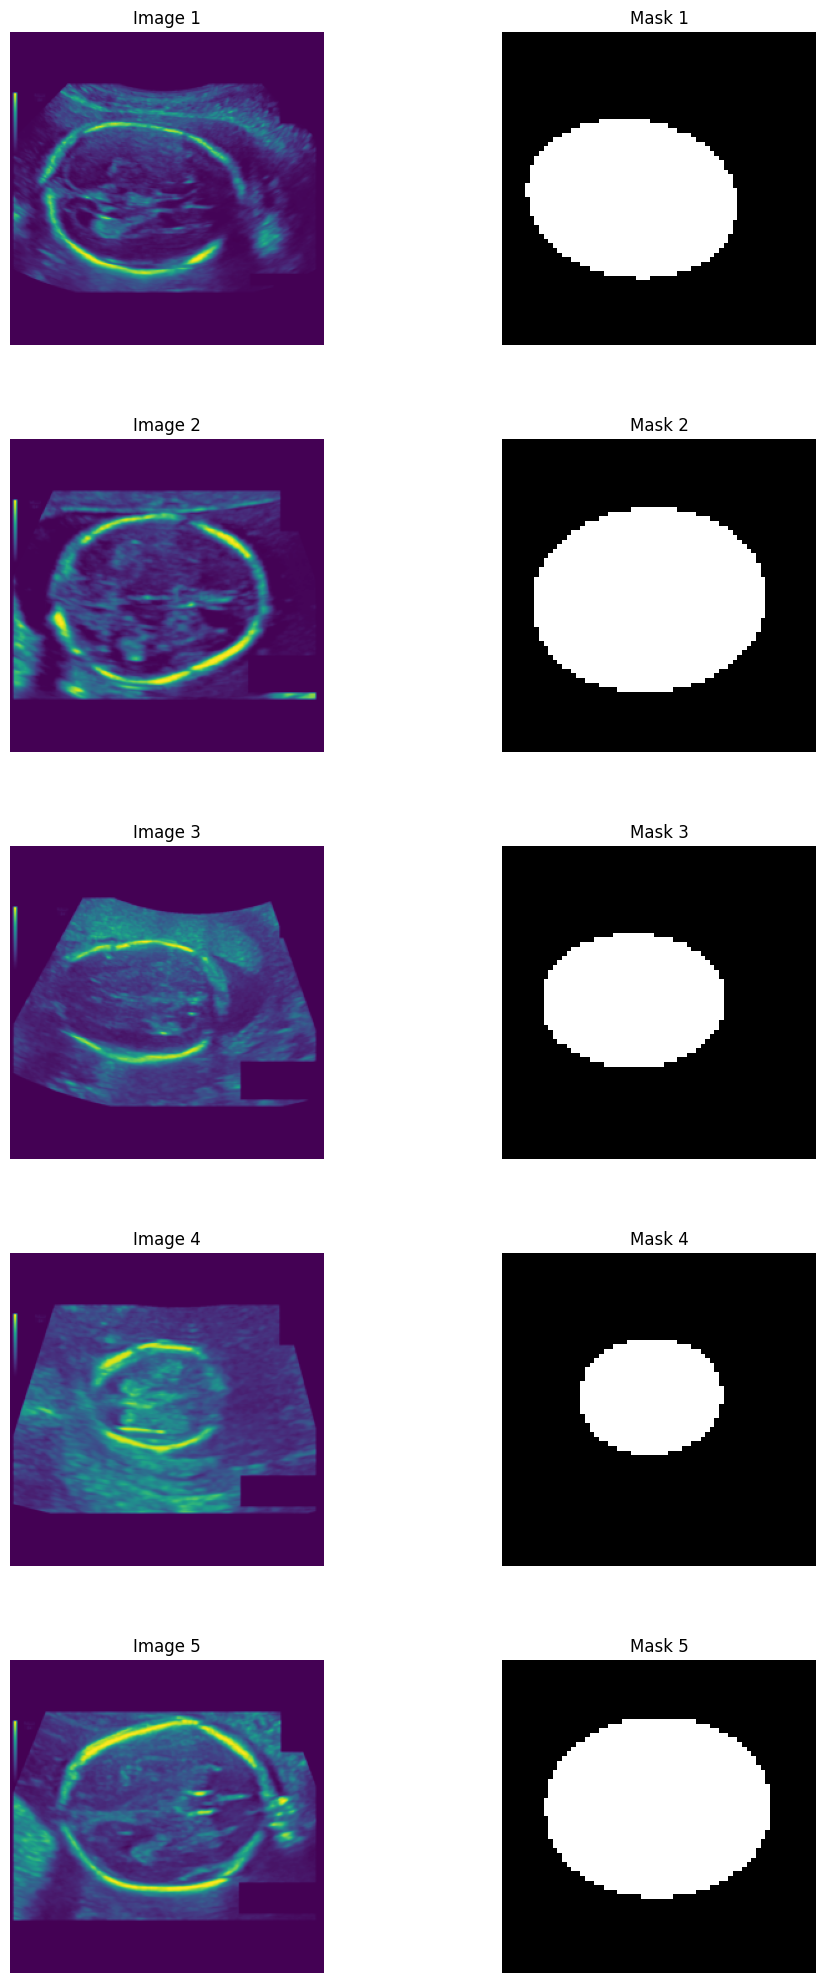

In [11]:
import matplotlib.pyplot as plt

# Retrieve 5 samples from the dataset
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
fig.tight_layout()

for i in range(5):
    # Get a random sample from the dataset
    img, mask = dataset[i]
    
    # Convert tensors for visualization
    img_np = img.permute(1, 2, 0).numpy()
    mask_np = mask.squeeze().numpy()
    
    # Display the image
    axs[i, 0].imshow(img_np)
    axs[i, 0].set_title(f'Image {i+1}')
    axs[i, 0].axis('off')
    
    # Display the mask
    axs[i, 1].imshow(mask_np, cmap='gray')
    axs[i, 1].set_title(f'Mask {i+1}')
    axs[i, 1].axis('off')

plt.subplots_adjust(hspace=0.3)
plt.show()

## Model
Please implement UNet in this section.
Refer to [this](https://www.google.com/url?sa=i&url=https%3A%2F%2Flmb.informatik.uni-freiburg.de%2Fpeople%2Fronneber%2Fu-net%2F&psig=AOvVaw1nv1l6Mrp_e0SWoWYZ4g2n&ust=1729346930454000&source=images&cd=vfe&opi=89978449&ved=0CBQQjRxqFwoTCKDim76NmIkDFQAAAAAdAAAAABAJ)  image for the model

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def scale_tensor(image, new_height, new_width):
    scaled_image = F.interpolate(image, size=(new_height, new_width), mode='bilinear', align_corners=True)
    return scaled_image

def crop_tensor(target_tensor, tensor):
    # Get target dimensions
    target_h, target_w = target_tensor.size()[2], target_tensor.size()[3]
    tensor_h, tensor_w = tensor.size()[2], tensor.size()[3]
    
    # Calculate offsets for center crop
    diff_h = tensor_h - target_h
    diff_w = tensor_w - target_w
    
    # Handle odd-sized differences
    start_h = diff_h // 2
    start_w = diff_w // 2
    end_h = start_h + target_h
    end_w = start_w + target_w
    
    # Ensure we don't go out of bounds
    start_h = max(0, start_h)
    start_w = max(0, start_w)
    end_h = min(tensor_h, end_h)
    end_w = min(tensor_w, end_w)
    
    # Perform the crop
    cropped = tensor[:, :, start_h:end_h, start_w:end_w]
    
    # If sizes still don't match (rare edge cases), resize
    if cropped.size()[2] != target_h or cropped.size()[3] != target_w:
        cropped = F.interpolate(cropped, size=(target_h, target_w), mode='bilinear', align_corners=True)
    
    return cropped

# Double 3x3 convolution
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.BatchNorm2d(in_channel),
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True)
    )
    return conv

def out_layer(in_channel, out_channel):
    conv_layer = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=1),
        nn.BatchNorm2d(out_channel),
        nn.Sigmoid()
    )
    return conv_layer

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Left side (contracting path)
        self.down_conv1 = dual_conv(1, 64)
        self.down_conv2 = dual_conv(64, 128)
        self.down_conv3 = dual_conv(128, 256)
        self.down_conv4 = dual_conv(256, 512)
        self.down_conv5 = dual_conv(512, 1024)
        
        self.conv_bn = nn.BatchNorm2d(1024) # hint, the size is 1024 at the bottleneck
        
        # Right side (expansion path)
        self.trans1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv1 = dual_conv(1024, 512)
        self.trans2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = dual_conv(512, 256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = dual_conv(256, 128)
        self.trans4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = dual_conv(128, 64)
        
        # Output layer
        self.out = out_layer(64, 1)

    def forward(self, image):
        # Forward pass for Left side (contracting path)
        x1 = self.down_conv1(image)
        x2 = self.maxpool(x1)
        
        x3 = self.down_conv2(x2)
        x4 = self.maxpool(x3)
        
        x5 = self.down_conv3(x4)
        x6 = self.maxpool(x5)
        
        x7 = self.down_conv4(x6)
        x8 = self.maxpool(x7)
        
        x9 = self.down_conv5(x8)
        x9 = self.conv_bn(x9)
        
        # Forward pass for Right side (expansion path)
        x = self.trans1(x9)
        
        # Crop and concatenate
        y7 = crop_tensor(x, x7)
        x = torch.cat([x, y7], dim=1)
        x = self.up_conv1(x)
        
        x = self.trans2(x)
        y5 = crop_tensor(x, x5)
        x = torch.cat([x, y5], dim=1)
        x = self.up_conv2(x)
        
        x = self.trans3(x)
        y3 = crop_tensor(x, x3)
        x = torch.cat([x, y3], dim=1)
        x = self.up_conv3(x)
        
        x = self.trans4(x)
        y1 = crop_tensor(x, x1)
        x = torch.cat([x, y1], dim=1)
        x = self.up_conv4(x)
        
        x = self.out(x)
        
        return x


## Training

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import gc
gc.collect()

# Check if MPS (Metal Performance Shaders) is available (for Apple Silicon)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Hyperparameters
learning_rate = 0.001
num_epochs = 5  # Reduced epochs for testing

# Define the U-Net architecture
model = Unet()
model.to(device)

# Define the loss function and optimizer
criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

v_loss, train_loss = [], []

# Train the U-Net
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        # Move tensors to the configured device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Convert inputs to expected format
        if inputs.shape[1] == 3:  # RGB to grayscale
            inputs = inputs.mean(dim=1, keepdim=True)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Resize targets if needed
        if outputs.shape != targets.shape:
            targets = F.interpolate(targets, size=outputs.shape[2:], mode='nearest')
        
        # Calculate loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average training loss for this epoch
    avg_train_loss = running_loss / len(train_dataloader)
    train_loss.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            if inputs.shape[1] == 3:
                inputs = inputs.mean(dim=1, keepdim=True)
            
            outputs = model(inputs)
            
            if outputs.shape != targets.shape:
                targets = F.interpolate(targets, size=outputs.shape[2:], mode='nearest')
            
            val_loss = criterion(outputs, targets)
            val_running_loss += val_loss.item()
    
    # Calculate average validation loss for this epoch
    avg_val_loss = val_running_loss / len(val_dataloader)
    v_loss.append(avg_val_loss)
    
    # Print losses only after each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'unet_model.pth')

Using MPS (Apple Silicon GPU)
Epoch [1/5], Train Loss: 0.4033, Val Loss: 0.3440
Epoch [2/5], Train Loss: 0.3133, Val Loss: 0.2905
Epoch [3/5], Train Loss: 0.2550, Val Loss: 0.2224
Epoch [4/5], Train Loss: 0.2132, Val Loss: 0.2274
Epoch [5/5], Train Loss: 0.1815, Val Loss: 0.1738


## Model Evaluation

This section contains code to assess the performance of our U-Net segmentation model. The evaluation uses the Dice coefficient, which measures the overlap between predicted and ground truth segmentation masks. In successful implementations, we typically expect Dice scores of 80% or higher, indicating good segmentation quality.

In [21]:
def dice_coefficient(y_pred, y_true):
    smooth = 0.001
    
    # Ensure tensors have the same shape before computing
    if y_pred.shape != y_true.shape:
        y_true = F.interpolate(y_true, size=y_pred.shape[1:], mode='nearest')
    
    y_pred = y_pred.view(-1)
    y_true = y_true.view(-1)
    
    intersection = torch.sum(y_pred * y_true)
    dice = (2.0 * intersection + smooth) / (torch.sum(y_pred) + torch.sum(y_true) + smooth)
    return dice

def dice_score(y_pred_batch, y_true_batch):
    # Ensure the shapes match before calling dice_coefficient
    if y_pred_batch.shape != y_true_batch.shape:
        y_true_batch = F.interpolate(y_true_batch, size=y_pred_batch.shape[2:], mode='nearest')
    
    dice_scores = torch.zeros(y_pred_batch.shape[0])
    for i in range(y_pred_batch.shape[0]):
        dice_scores[i] = dice_coefficient(y_pred_batch[i], y_true_batch[i])
    return dice_scores

with torch.no_grad():
    dice_com = torch.tensor([])
    model.to(device)
    model.eval()
    val_loss = 0
    for inputs, targets in val_dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Process inputs if they are RGB
        if inputs.shape[1] == 3:
            inputs = inputs.mean(dim=1, keepdim=True)
            
        outputs = model(inputs)
        
        # Ensure targets match output shape before evaluation
        if outputs.shape != targets.shape:
            targets = F.interpolate(targets, size=outputs.shape[2:], mode='nearest')
        
        outputs = torch.where(outputs > 0.5, torch.tensor([1.0]).to(device), torch.tensor([0.0]).to(device))
        dice = dice_score(outputs, targets)
        dice_com = torch.cat((dice_com.to(device), dice.to(device)))

print("Dice Score of Validation Set")
mean_dice = dice_com.mean().item()
print(f"Mean Dice Score: {mean_dice:.4f} ({mean_dice*100:.2f}%)")

Dice Score of Validation Set
Mean Dice Score: 0.9168 (91.68%)


2140

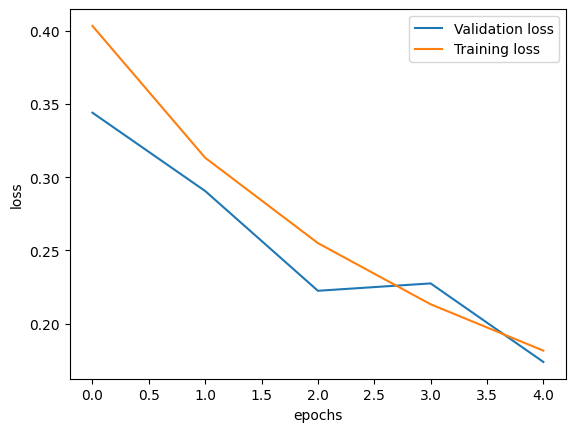

In [22]:
import matplotlib.pyplot as plt
plt.plot(v_loss)
plt.plot(train_loss)
plt.legend(["Validation loss" , "Training loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

## Inference on the Test set
Iterate on the test data and calculate the predicted mask for each sample

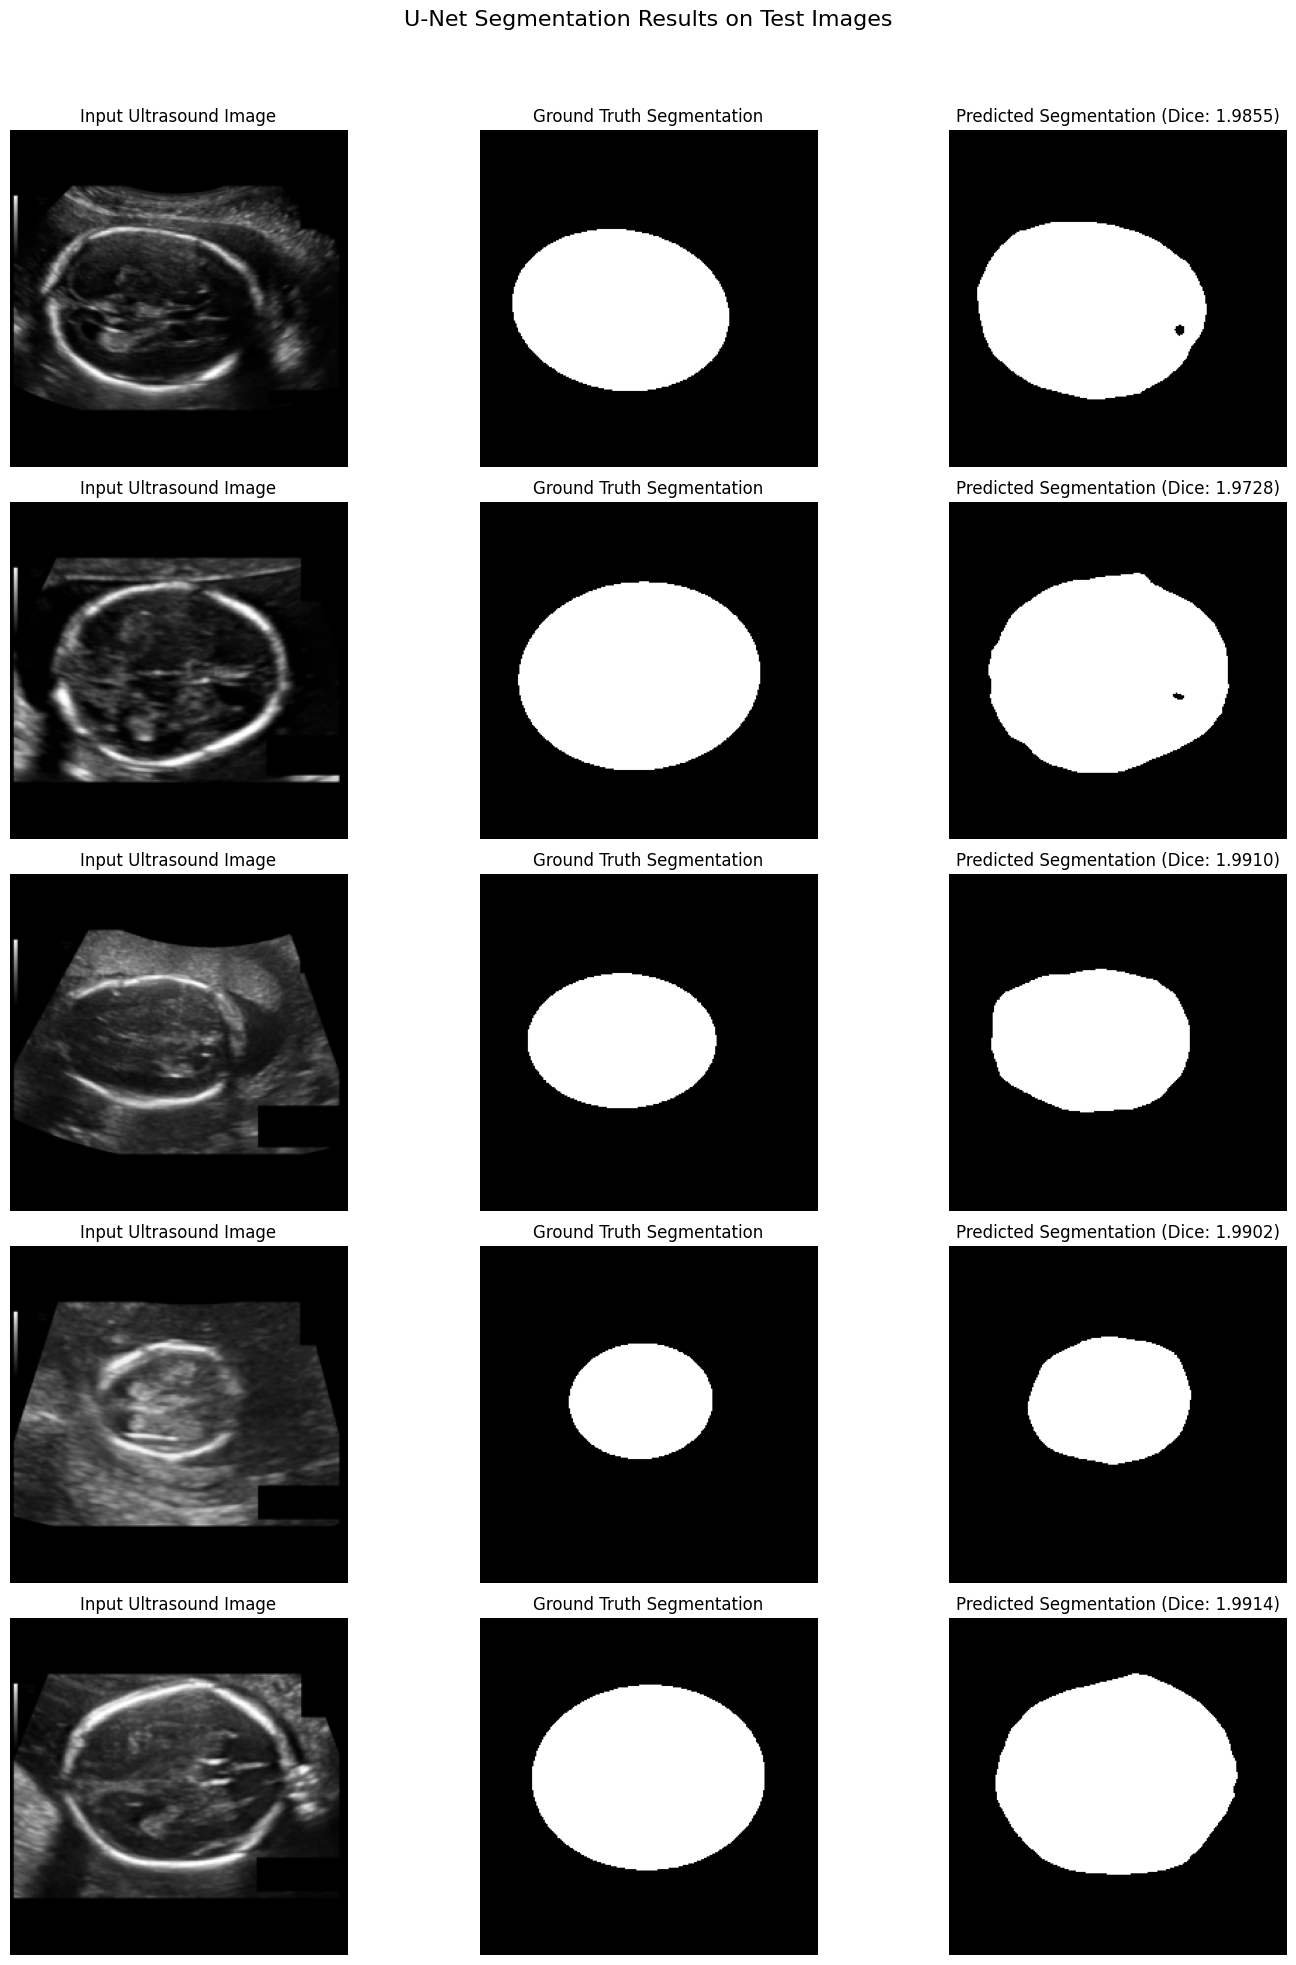

In [24]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Set model to evaluation mode
model.to(device)
model.eval()

# Number of samples to visualize
n_samples = 5

with torch.no_grad():
    # Get test samples
    test_iterator = iter(test_dataloader)
    samples = []
    
    fig, axs = plt.subplots(n_samples, 3, figsize=(15, n_samples * 4))
    
    # Track test set metrics
    test_dice_scores = []
    
    for i in range(n_samples):
        try:
            inputs, targets = next(test_iterator)
        except StopIteration:
            break
            
        # Move to device
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Convert inputs to grayscale if needed
        if inputs.shape[1] == 3:
            input_display = inputs.clone()  # Keep original for display
            inputs = inputs.mean(dim=1, keepdim=True)
        else:
            input_display = inputs
        
        # Make prediction
        outputs = model(inputs)
        
        # Convert to binary mask
        pred_masks = (outputs > 0.5).float()
        
        # Ensure targets and outputs have the same shape
        if outputs.shape != targets.shape:
            targets = F.interpolate(targets, size=outputs.shape[2:], mode='nearest')
        
        # Calculate Dice score
        dice = dice_coefficient(pred_masks, targets).item()
        test_dice_scores.append(dice)
        
        # Move tensors back to CPU and convert to numpy for plotting
        input_np = input_display[0].cpu().permute(1, 2, 0).numpy()
        if input_np.shape[2] == 1:  # If grayscale
            input_np = input_np[:, :, 0]
        target_np = targets[0, 0].cpu().numpy()
        pred_np = pred_masks[0, 0].cpu().numpy()
        
        # Plot
        axs[i, 0].imshow(input_np, cmap='gray' if len(input_np.shape) == 2 else None)
        axs[i, 0].set_title("Input Ultrasound Image")
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(target_np, cmap='gray')
        axs[i, 1].set_title("Ground Truth Segmentation")
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(pred_np, cmap='gray')
        axs[i, 2].set_title(f"Predicted Segmentation (Dice: {dice:.4f})")
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle("U-Net Segmentation Results on Test Images", fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()